In [1]:
import gym
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# 导入小车上山环境

env = gym.make('MountainCar-v0')
env.seed(0)

print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.min_position, env.max_position)))
print('速度范围 = {}'.format((-env.max_speed, env.max_speed)))
print('目标位置 = {}'.format(env.goal_position))

观测空间 = Box(2,)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


d:\programdata\miniconda3\envs\rl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


失败退出


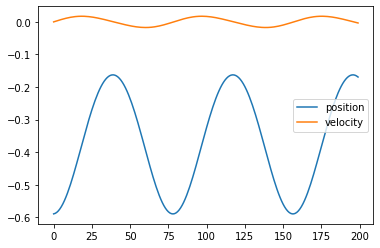

In [3]:
# 总是向右施力的智能体

positions, velocities = [], []
observation = env.reset()

while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

plt.figure()
plt.plot(positions, label='position')
plt.plot(velocities, label='velocity')
plt.legend()
plt.show()

In [4]:
# 砖瓦编码的实现

class TileCoder(object):
    
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}
        return

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]

        count = len(self.codebook)
        if count >= self.features:
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
    
    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [5]:
# SARSA智能体与环境交互一回合

def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    
    while True:
        if render:
            env.render()
        
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation)
        
        if train:
            agent.learn(observation, action, reward, next_observation, done, next_action)
        
        if done:
            break
        
        observation, action = next_observation, next_action

    return episode_reward

In [6]:
# 函数近似SARSA算法智能体

class SARSAAgent(object):
    
    def __init__(self, env, layers=8, features=1893, gamma=1.0, learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - env.observation_space.low
        self.encoder = TileCoder(layers, features)
        self.w = np.zeros(features)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        return
    
    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action):
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in range(self.action_n)]
            return np.argmax(qs)
    
    def learn(self, observation, action, reward, next_observation, done, next_action):
        u = reward + (1.0 - done) * self.gamma * self.get_q(next_observation, next_action)
        td_error = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += self.learning_rate * td_error
        return

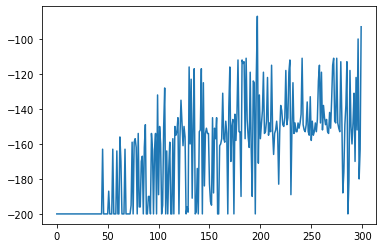

In [7]:
# 训练SARSA算法

agent = SARSAAgent(env)

episodes = 300
episode_rewards = []
for episode in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [8]:
# 测试SARSA算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = -131.42 


In [9]:
# SARSA(lambda)算法智能体类

class SARSALambdaAgent(SARSAAgent):
    
    def __init__(self, env, layers=8, features=1893, gamma=1.0, learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super(SARSALambdaAgent, self).__init__(env, layers, features, gamma, learning_rate, epsilon)
        self.lambd = lambd
        self.z = np.zeros(features)
        return
    
    def learn(self, observation, action, reward, next_observation, done, next_action):
        u = reward
        if not done:
            u += self.gamma * self.get_q(next_observation, next_action)
            self.z *= self.gamma * self.lambd
            features = self.encode(observation, action)
            self.z[features] = 1.0
        td_error = u - self.get_q(observation, action)
        self.w += self.learning_rate * td_error * self.z
        if done:
            self.z = np.zeros_like(self.z)
        return

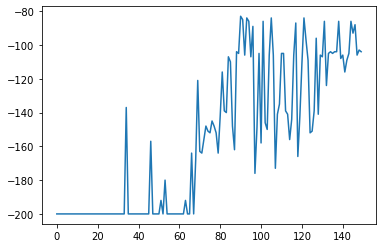

In [10]:
# 训练SARSA(lambda)

agent = SARSALambdaAgent(env)
episodes = 150
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [11]:
# 测试SARSA(lambda)算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = -108.75 


In [12]:
# 经验回放的实现

class DQNReplayer(object):
    
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity), columns=['observation', 'action', 'reward', 'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
        return
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        return
    
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in self.memory.columns)

In [13]:
# 带目标网络的深度Q学习智能体

class DQN(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DQN, self).__init__()
        
        neurons = [input_size] + hidden_sizes
        layers = []
        for i in range(len(neurons) - 1):
            layers.append(nn.Linear(neurons[i], neurons[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(neurons[-1], output_size))
        self.net = nn.Sequential(*layers)
        return

    def forward(self, x):
        return self.net(x)


class DQNAgent(object):
    
    def __init__(self, env, net_kwargs={}, gamma=0.99, epsilon=0.001, replayer_capacity=10000, batch_size=64):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        
        self.evaluate_net = DQN(observation_dim, net_kwargs['hidden_sizes'], self.action_n)
        self.evaluate_net.train()
        self.target_net = DQN(observation_dim, net_kwargs['hidden_sizes'], self.action_n)
        self.target_net.load_state_dict(self.evaluate_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=net_kwargs['learning_rate'])
        self.criterion = nn.MSELoss()
        return
    
    @staticmethod
    def __tensor2numpy(tensor):
        return tensor.cpu().detach().numpy()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)

        qs = self.evaluate_net(torch.tensor(observation[np.newaxis]).float())
        qs = self.__tensor2numpy(qs)
        return np.argmax(qs)
    
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation, done)
        observations, actions, rewards, next_observations, dones = self.replayer.sample(self.batch_size)
        
        next_qs = self.target_net(torch.tensor(next_observations).float())
        next_max_qs = self.__tensor2numpy(next_qs).max(axis=-1)
        us = rewards + self.gamma * (1.0 - dones) * next_max_qs
        
        observations_tensor = torch.tensor(observations).float()
        targets = self.evaluate_net(observations_tensor)
        targets = self.__tensor2numpy(targets)
        targets[np.arange(us.shape[0]), actions] = us
        targets = torch.tensor(targets)

        preds = self.evaluate_net(observations_tensor)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if done:
            self.target_net.load_state_dict(self.evaluate_net.state_dict())
        return

In [14]:
# 期望SARSA智能体或Q学习智能体与环境的交互

def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()

    while True:
        if render:
            env.render()
        
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        
        if train:
            agent.learn(observation, action, reward, next_observation, done)

        if done:
            break
        
        observation = next_observation
    
    return episode_reward

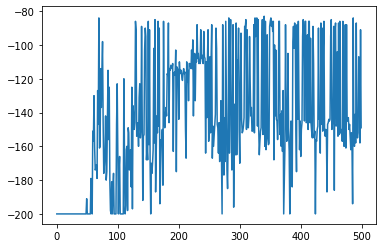

In [15]:
# 训练带目标网络的深度Q学习智能体

net_kwargs = dict(hidden_sizes=[128,], learning_rate=0.01)
agent = DQNAgent(env, net_kwargs=net_kwargs)

episodes = 500
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [16]:
# 测试带目标网络的深度Q学习智能体

agent.epsilon = 0.0
episode_rewards = []
for _ in tqdm(range(100)):
    episode_rewards.append(play_qlearning(env, agent))
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))


平均回合奖励 = -125.95 


In [24]:
# 双重深度Q学习智能体

class DoubleDQNAgent(DQNAgent):

    @staticmethod
    def __tensor2numpy(tensor):
        return tensor.cpu().detach().numpy()
    
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation, done)
        observations, actions, rewards, next_observations, dones = self.replayer.sample(self.batch_size)
        
        observations_tensor = torch.tensor(observations).float()
        next_observations_tensor = torch.tensor(next_observations).float()
        
        next_eval_qs = self.evaluate_net(next_observations_tensor)
        next_actions = self.__tensor2numpy(next_eval_qs).argmax(axis=-1)
        next_qs = self.__tensor2numpy(self.target_net(next_observations_tensor))
        next_max_qs = next_qs[np.arange(next_qs.shape[0]), next_actions]
        us = rewards + self.gamma * (1.0 - dones) * next_max_qs

        targets = self.evaluate_net(observations_tensor)
        targets = self.__tensor2numpy(targets)
        targets[np.arange(us.shape[0]), actions] = us
        targets = torch.tensor(targets)

        preds = self.evaluate_net(observations_tensor)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if done:
            self.target_net.load_state_dict(self.evaluate_net.state_dict())

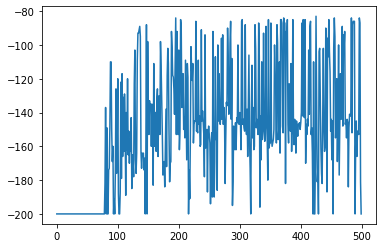

In [25]:
# 训练双重深度Q学习智能体

net_kwargs = dict(hidden_sizes=[128,], learning_rate=0.01)
agent = DoubleDQNAgent(env, net_kwargs=net_kwargs)

episodes = 500
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [26]:
# 测试双重深度Q学习智能体

agent.epsilon = 0.0
episode_rewards = []
for _ in tqdm(range(100)):
    episode_rewards.append(play_qlearning(env, agent))
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))


平均回合奖励 = -140.72 
